## 목표 : 부족한 피쳐를 조합 생성하여 모델 성능 향상

- 특성 공학 => 피쳐 추출/선택/생성
- 비선형의 데이터에 대한 피쳐 생성 ==> 곡선 형태의 회귀선 수식
- 모듈 : sklearn.preprocessing 내에 포함
- 데이터 : fish.csv
- 피쳐 : Perch의 Height, Width, Length
- 타켓 : Perch의 Weight
- 학습 유형 : 지도 학습


### (1) 전처리 feature 조합 생성 살펴보기

In [2]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(
    include_bias=False,
    # interaction_only=True,
    degree=5,
)
poly.fit([[2,3]])
poly.transform([[2,3]])
# for x in dir(poly):
#     if x.find('._') <0:
#         # print(getattr(poly, x), x)
#         pass

array([[  2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.,  16.,  24.,
         36.,  54.,  81.,  32.,  48.,  72., 108., 162., 243.]])

### (2) Perch Data 를 최대한 만족하는 회귀선을 찾기
<hr>

#### (2-1) 모듈 로딩 및 데이터 준비
<hr>


In [3]:

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# 나눔고딕
mpl.rc('font', family='NanumGothic')
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# 1. 데이터 로드
df = pd.read_csv("../data/fish.csv")
mask = df['Species'] == 'Perch'
df = df[mask]
df = df.drop(['Species', 'Diagonal'], axis=1)

In [5]:
df.reset_index(drop=True, inplace=True)
df.tail()
df.shape

(56, 4)

In [6]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  56 non-null     float64
 1   Length  56 non-null     float64
 2   Height  56 non-null     float64
 3   Width   56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


#### (2-2) 데이터 확인
<hr>

- 학습 유형 결정위한 단계
- 피쳐 스케일링 진행 여부 체크


Text(0.5, 1.0, 'Perch Weight vs Length')

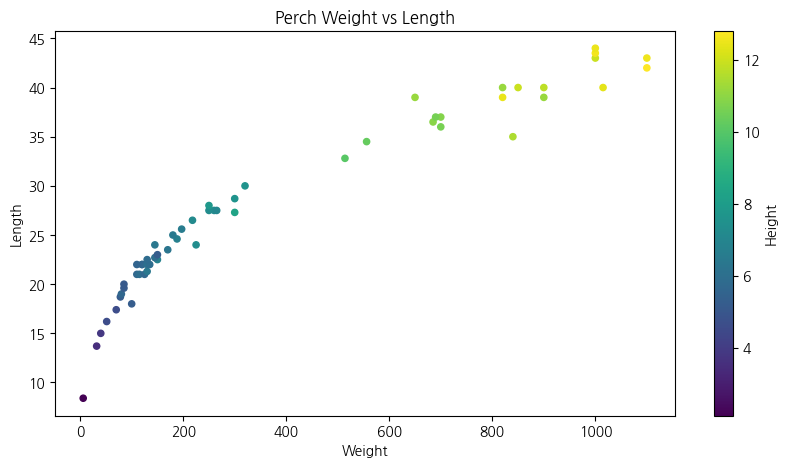

In [7]:

fig, ax = plt.subplots(1,1, figsize=(10,5))
df.plot(kind='scatter' ,x='Weight', y='Length', c='Height', colormap='viridis', ax=ax)
plt.title('Perch Weight vs Length')
# 숫자의 범위가 매우 차이나므로 스케일링 필요


In [8]:
from sklearn.model_selection import train_test_split
target = 'Weight'
X = df.drop([target], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [10]:
poly = PolynomialFeatures(
    degree=2,
    include_bias=False,
    interaction_only=True,
)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)


In [11]:
from sklearn.pipeline import Pipeline

model = Pipeline(
    [   ('scalerSTD', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression(fit_intercept=False)),
    ]
)
model

Pipeline(steps=[('scalerSTD', StandardScaler()), ('poly', PolynomialFeatures()),
                ('linear', LinearRegression(fit_intercept=False))])

In [12]:
model.fit(X_train, y_train)

Pipeline(steps=[('scalerSTD', StandardScaler()), ('poly', PolynomialFeatures()),
                ('linear', LinearRegression(fit_intercept=False))])

In [13]:
model.score(X_test, y_test)

linearOnly = LinearRegression()
linearOnly.fit(X_train_scaled, y_train)
linearOnly.score(X_test_scaled, y_test)


0.8931862140089063

In [15]:

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = model.predict(X_test)
resultmodel = [
    mean_squared_error(y_test, y_pred, squared=False),
    r2_score(y_test, y_pred),
    mean_absolute_error(y_test, y_pred),
]
resultmodel = list(map(lambda x: round(x, 4), resultmodel))
resultmodel

[52.327, 0.9765, 29.2493]